In [1]:
import fairbench as fb
import numpy as np

# Load data
Automatically download the adult dataset, read it (with pandas).

In [2]:
train = fb.read_csv("adult/adult.data", header=None, skipinitialspace=True)
test = fb.read_csv("adult/adult.test", header=None, skipinitialspace=True, skiprows=[0])
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Convert training and test data into numpy arrays by considering some numeric and categorical columns.

In [3]:
numeric = [0, 4, 11, 12]
categorical = [1, 3, 5, 6]

x_train = fb.features(train, numeric, categorical)
y_train = (train[14]==">50K").values

x = fb.features(test, numeric, categorical)
y = (test[14]==">50K.").values

# Make AI predictions
This demonstration will use sklearn for simplicity, but this library also accepts pytorch or tensorflow tensors or any kind of numpy array. Inputs are scaled.

In [4]:
import sklearn
from sklearn.linear_model import LogisticRegression

x_train_scaled = sklearn.preprocessing.MinMaxScaler().fit_transform(x_train)
x = sklearn.preprocessing.MinMaxScaler().fit_transform(x)

classifier = LogisticRegression(max_iter=1000)
classifier = classifier.fit(x_train_scaled, y_train)
yhat = classifier.predict(x)

# Define sensitive attribute Fork
Determine sensitive attribute columns and organize them into Forks of fairness attributes. Forks define computational branches of population groups (a branch is a sensitive attribute column with binary values indicating membership to each group, e.g., Male, Female). Base measures will be computed independently on each branch to be compared. Fork branches can be automatically unpacked from iterables (e.g., arrays, lists, pandas columns) or manually by naming branches with keyword arguments in the Fork contructor. 

In [5]:
sensitive = fb.Fork(fb.categories@test[9])  # or sensitive = fb.Fork(Male=np.array(...), Female=np.array(...))
print(sensitive.Male)
sensitive

NumPyTensor(array([1, 1, 1, ..., 1, 1, 1]))


Female,[0 0 0 ... 0 0 0]
Male,[1 1 1 ... 1 1 1]


Most operations are overloaded in forks. Here we will sum the sensitive attribute columns to obtain the presence of population groups in the data. Forks of numeric values and reports later on can be visualized or outputted in text form.

Female: 5421
Male: 10860


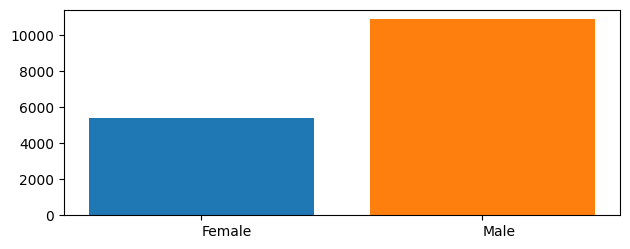

In [6]:
presence = sensitive.sum()
print(presence)
fb.visualize(presence)

# Performance measures and reports
Individual performance measures can be computed per branch, i.e., sensitive attribute column. Can use the ipython display to show prettier representations instead of printing them.

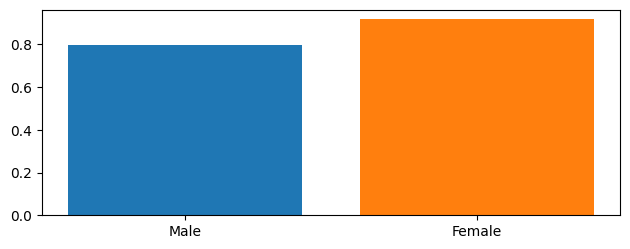

Male,0.7985267034990792
Female,0.9166205497140749


In [7]:
acc = fb.accuracy(predictions=yhat, labels=y, sensitive=sensitive)
fb.visualize(acc)
acc

Multiple measures can be computed and organized into reports, whose arguments will automatically be determined from keyword arguments.

In [7]:
report = fb.report(predictions=yhat, labels=y, sensitive=sensitive, metrics=[fb.accuracy, fb.pr, fb.tpr, fb.tnr])
report

accuracy,0.917
pr,0.054
tpr,0.736
tnr,0.927
accuracy,0.799
pr,0.255
tpr,0.693
tnr,0.834


Some popular measures are provided by the binreport. This and previous code analyse each sensitive attribute branch independently (make an one-vs-all analysis for sensitive attribute values).

In [8]:
report = fb.binreport(predictions=yhat, labels=y, sensitive=sensitive)
report

accuracy,0.917
prule,0.2116387709158066
dfpr,-0.04310310647661719
dfnr,-0.09240016661053899
accuracy,0.799
prule,0.2116387709158066
dfpr,0.04310310647661719
dfnr,0.09240016661053899


Reports can be printed, outputted as textual tables, or visualized.

In [10]:
print(report)

Male: 
   accuracy: 0.799
   prule: 0.212
   dfpr: 0.043
   dfnr: 0.092
Female: 
   accuracy: 0.917
   prule: 0.212
   dfpr: -0.043
   dfnr: -0.092


In [11]:
fb.describe(report)

Metric          Male            Female         
accuracy        0.799           0.917          
prule           0.212           0.212          
dfpr            0.043           -0.043         
dfnr            0.092           -0.092         



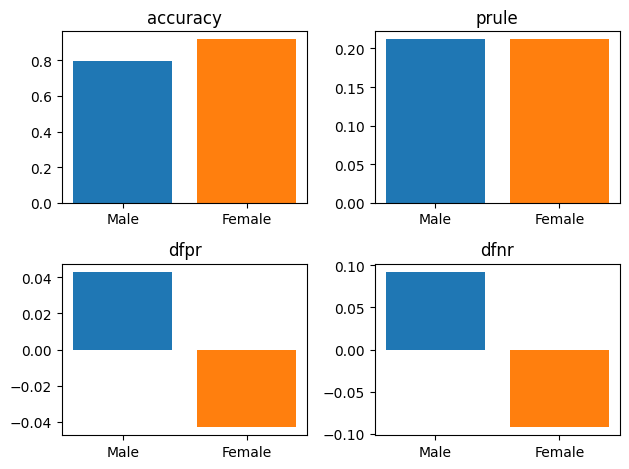

In [12]:
fb.visualize(report)

# Reports and customization
The preferred type of reporting for complex fairness assessment settings should be multireports. These make pairwise comparisons between all sensitive attribute branches (i.e., columns) and run reduction operations to summarize the result in terms of minimum measure values, minimum ratio of group assessment, or maximum difference of group assessment. These three types of reductions will always produce three branches, no matter how many sensitive attribute branches are there. That is, multireports are forks with three branches, where each branch holds the outcome of a different reduction.

In [13]:
report = fb.multireport(predictions=yhat, labels=y, sensitive=sensitive)
report

accuracy,0.799
pr,0.054
tpr,0.693
tnr,0.834
accuracy,0.871
pr,0.212
tpr,0.941
tnr,0.900
accuracy,0.118
pr,0.201
tpr,0.043


In [10]:
fb.interactive(report)

Loading BokehJS ...

All reports can be computed on specific measures.

In [14]:
report = fb.multireport(predictions=yhat, labels=y, sensitive=sensitive, metrics=[fb.accuracy, fb.pr, fb.tpr])
report

accuracy,0.799
pr,0.054
tpr,0.693
accuracy,0.871
pr,0.212
tpr,0.941
accuracy,0.118
pr,0.201
tpr,0.043


Can unpack reports by accessing rows or columns as members.

In [15]:
report.accuracy # this is also a Fork, since it would obtain a unique value for each branch

min,0.799
minratio,0.871
maxdiff,0.118


In [16]:
report.min  # this is a dictionary of assessments

{'accuracy': 0.7985267034990792,
 'pr': 0.053864600627190555,
 'tpr': 0.6931982633863966}

You can also erase entries from each branch thank to transparent wrapping of of branch data objects, i.e., the same mechanism that let us compute sensitive.sum() for each branch.

In [17]:
del report["accuracy"]
report

pr,0.054
tpr,0.693
pr,0.212
tpr,0.941
pr,0.201
tpr,0.043


Custom reductions can be created with the corresponding interface. These will be reports.

In [18]:
fpr = fb.fpr(predictions=yhat, labels=y, sensitive=sensitive)
fb.reduce(fpr, fb.min, fb.ratio)

minratio,0.860


A Fork combining the branches of several Forks can be created.

In [19]:
fpr_reduced = fb.combine(fb.reduce(fpr, fb.min), fb.reduce(fpr, fb.min, fb.ratio), fb.reduce(fpr, fb.max, fb.diff))
fpr_reduced

min,0.264
minratio,0.860
maxdiff,0.043


Seveal Forks with the same branches can be converted to reports via a todict method, which takes any number of keyword arguments to create corresponding dictionary entries on each branch.

In [20]:
fpr_report = fb.todict(fpr=fpr_reduced)
fpr_report

fpr,0.043
fpr,0.264
fpr,0.860


For multiple reports with the same branch names, dictionaries of measure values on each branch can be combined with the | operator (in Python 3.9 or later).

In [21]:
report | fpr_report

pr,0.201
tpr,0.043
fpr,0.043
pr,0.054
tpr,0.693
fpr,0.264
pr,0.212
tpr,0.941
fpr,0.860


# Explain report values
Report values are of type Explainable. This has a value and an explain field. 

In [22]:
print(report.minratio.pr)
type(report.minratio.pr)

0.212


fairbench.forks.explanation.Explainable

In [23]:
print(report.minratio.pr.value)
print(report.minratio.pr.explain)

0.2116387709158066
Male: 0.255
Female: 0.054


The explain field is a Fork that keeps track of individual evaluations that have contributed to the result. This way, we can backtrack explanations and find which groups are more disadvantaged after finding measures on which imbalances exist.

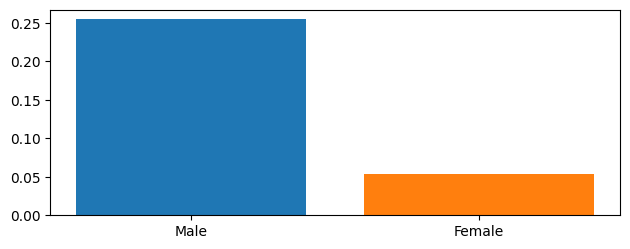

In [24]:
fb.visualize(report.minratio.pr.explain)

# Intersectional fainress
More than one unpacked sensitive attributes or multiple columns from several attributes can be provided to Fork consutructors.

In [25]:
sensitive = fb.Fork(fb.categories@test[9], fb.categories@test[8])
sensitive.sum()

Male,10860
Female,5421
Amer-Indian-Eskimo,159
White,13946
Black,1561
Asian-Pac-Islander,480
Other,135


Appending all non-empty intersections of pairs of columns to the sensitive attribute to perform intersectional analyasis.

In [26]:
sensitive_intersections = sensitive.intersectional()
sensitive_intersections.sum()

Other,135
Asian-Pac-Islander,480
Black,1561
White,13946
Amer-Indian-Eskimo,159
Female,5421
Female&Other,46
Female&Asian-Pac-Islander,171
Female&Black,753
Female&White,4385
Female&Amer-Indian-Eskimo,66


Can create a normal report for intersectional fairness.

In [27]:
report = fb.multireport(predictions=yhat, labels=y, sensitive=sensitive_intersections)
report

accuracy,0.783
pr,0.015
tpr,0.000
tnr,0.827
accuracy,0.822
pr,0.043
tpr,0.000
tnr,0.858
accuracy,0.169
pr,0.334
tpr,0.900


In [28]:
report.min.accuracy.explain

Female&Black,0.952191235059761
Male,0.7985267034990792
White,0.8299870930732827
Amer-Indian-Eskimo,0.89937106918239
Male&White,0.792594916849702
Female&Amer-Indian-Eskimo,0.9393939393939394
Female&Asian-Pac-Islander,0.8830409356725146
Male&Other,0.8651685393258427
Black,0.9039077514413837
Female&White,0.9115165336374003
Female,0.9166205497140749


The worst accuracy is for Male&Asian-Pac-Islander, which means that any bias mitigation should start from exploring issues that arise for this subgroup.